In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

# from warpctc_pytorch import CTCLoss

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

ascii                paragraphs.csv       words.csv
chars.csv            sentences            words10.csv
forms                synth_words          words_chars.csv
line_labels.csv      synth_words.csv      xml
lines                synth_words_1000.csv xml.tgz
models               tmp
paragraphs           words


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Converting forms to paragraphs

## crop forms via xml info

In [14]:
import xml.etree.ElementTree as ET
xml = PATH/'xml'

def parse_xml(fname):
    tree = ET.parse(xml/fname)
    root = tree.getroot()
    
    words = []
    for part in root:
        for line in part:
            for word in line.findall('word'):
                for cmp in word:
                    x,y = int(cmp.attrib['x']), int(cmp.attrib['y'])
                    rx,ry = x+int(cmp.attrib['width']), y+int(cmp.attrib['height'])
                    words.append((x,y,rx,ry))
    
    # convert to numpy
    w = np.array(words)
    # create box w/ padding    # need top,left and height,width
    min_x = np.min(w[:,0])-50
    min_y = np.min(w[:,1])-50
    max_x = np.max(w[:,2])+50
    max_y = np.max(w[:,3])+50
    box = (min_x, min_y, max_x, max_y)
    return box

In [15]:
def crop_and_save(fname, box):
    im = Image.open(PATH/'forms'/fname)
    im = im.crop(box)
    im.save(PATH/'paragraphs'/fname)

In [8]:
folder = PATH/'forms'
files = []
for file in os.listdir(folder):
    files.append(file)
files.sort()

In [27]:
os.makedirs(PATH/'paragraphs', exist_ok=True)

In [40]:
for fname in files:
    box = parse_xml(fname[:-4]+'.xml')
    crop_and_save(fname, box)

In [9]:
def show_rand_paragraph(fnames):
    r = random.randint(0, len(fnames))
    fname = fnames[r]
    im = Image.open(PATH/'paragraphs'/fname)
    print(fname)
    print(im.size)
    return im

f07-009.png
(2081, 1823)


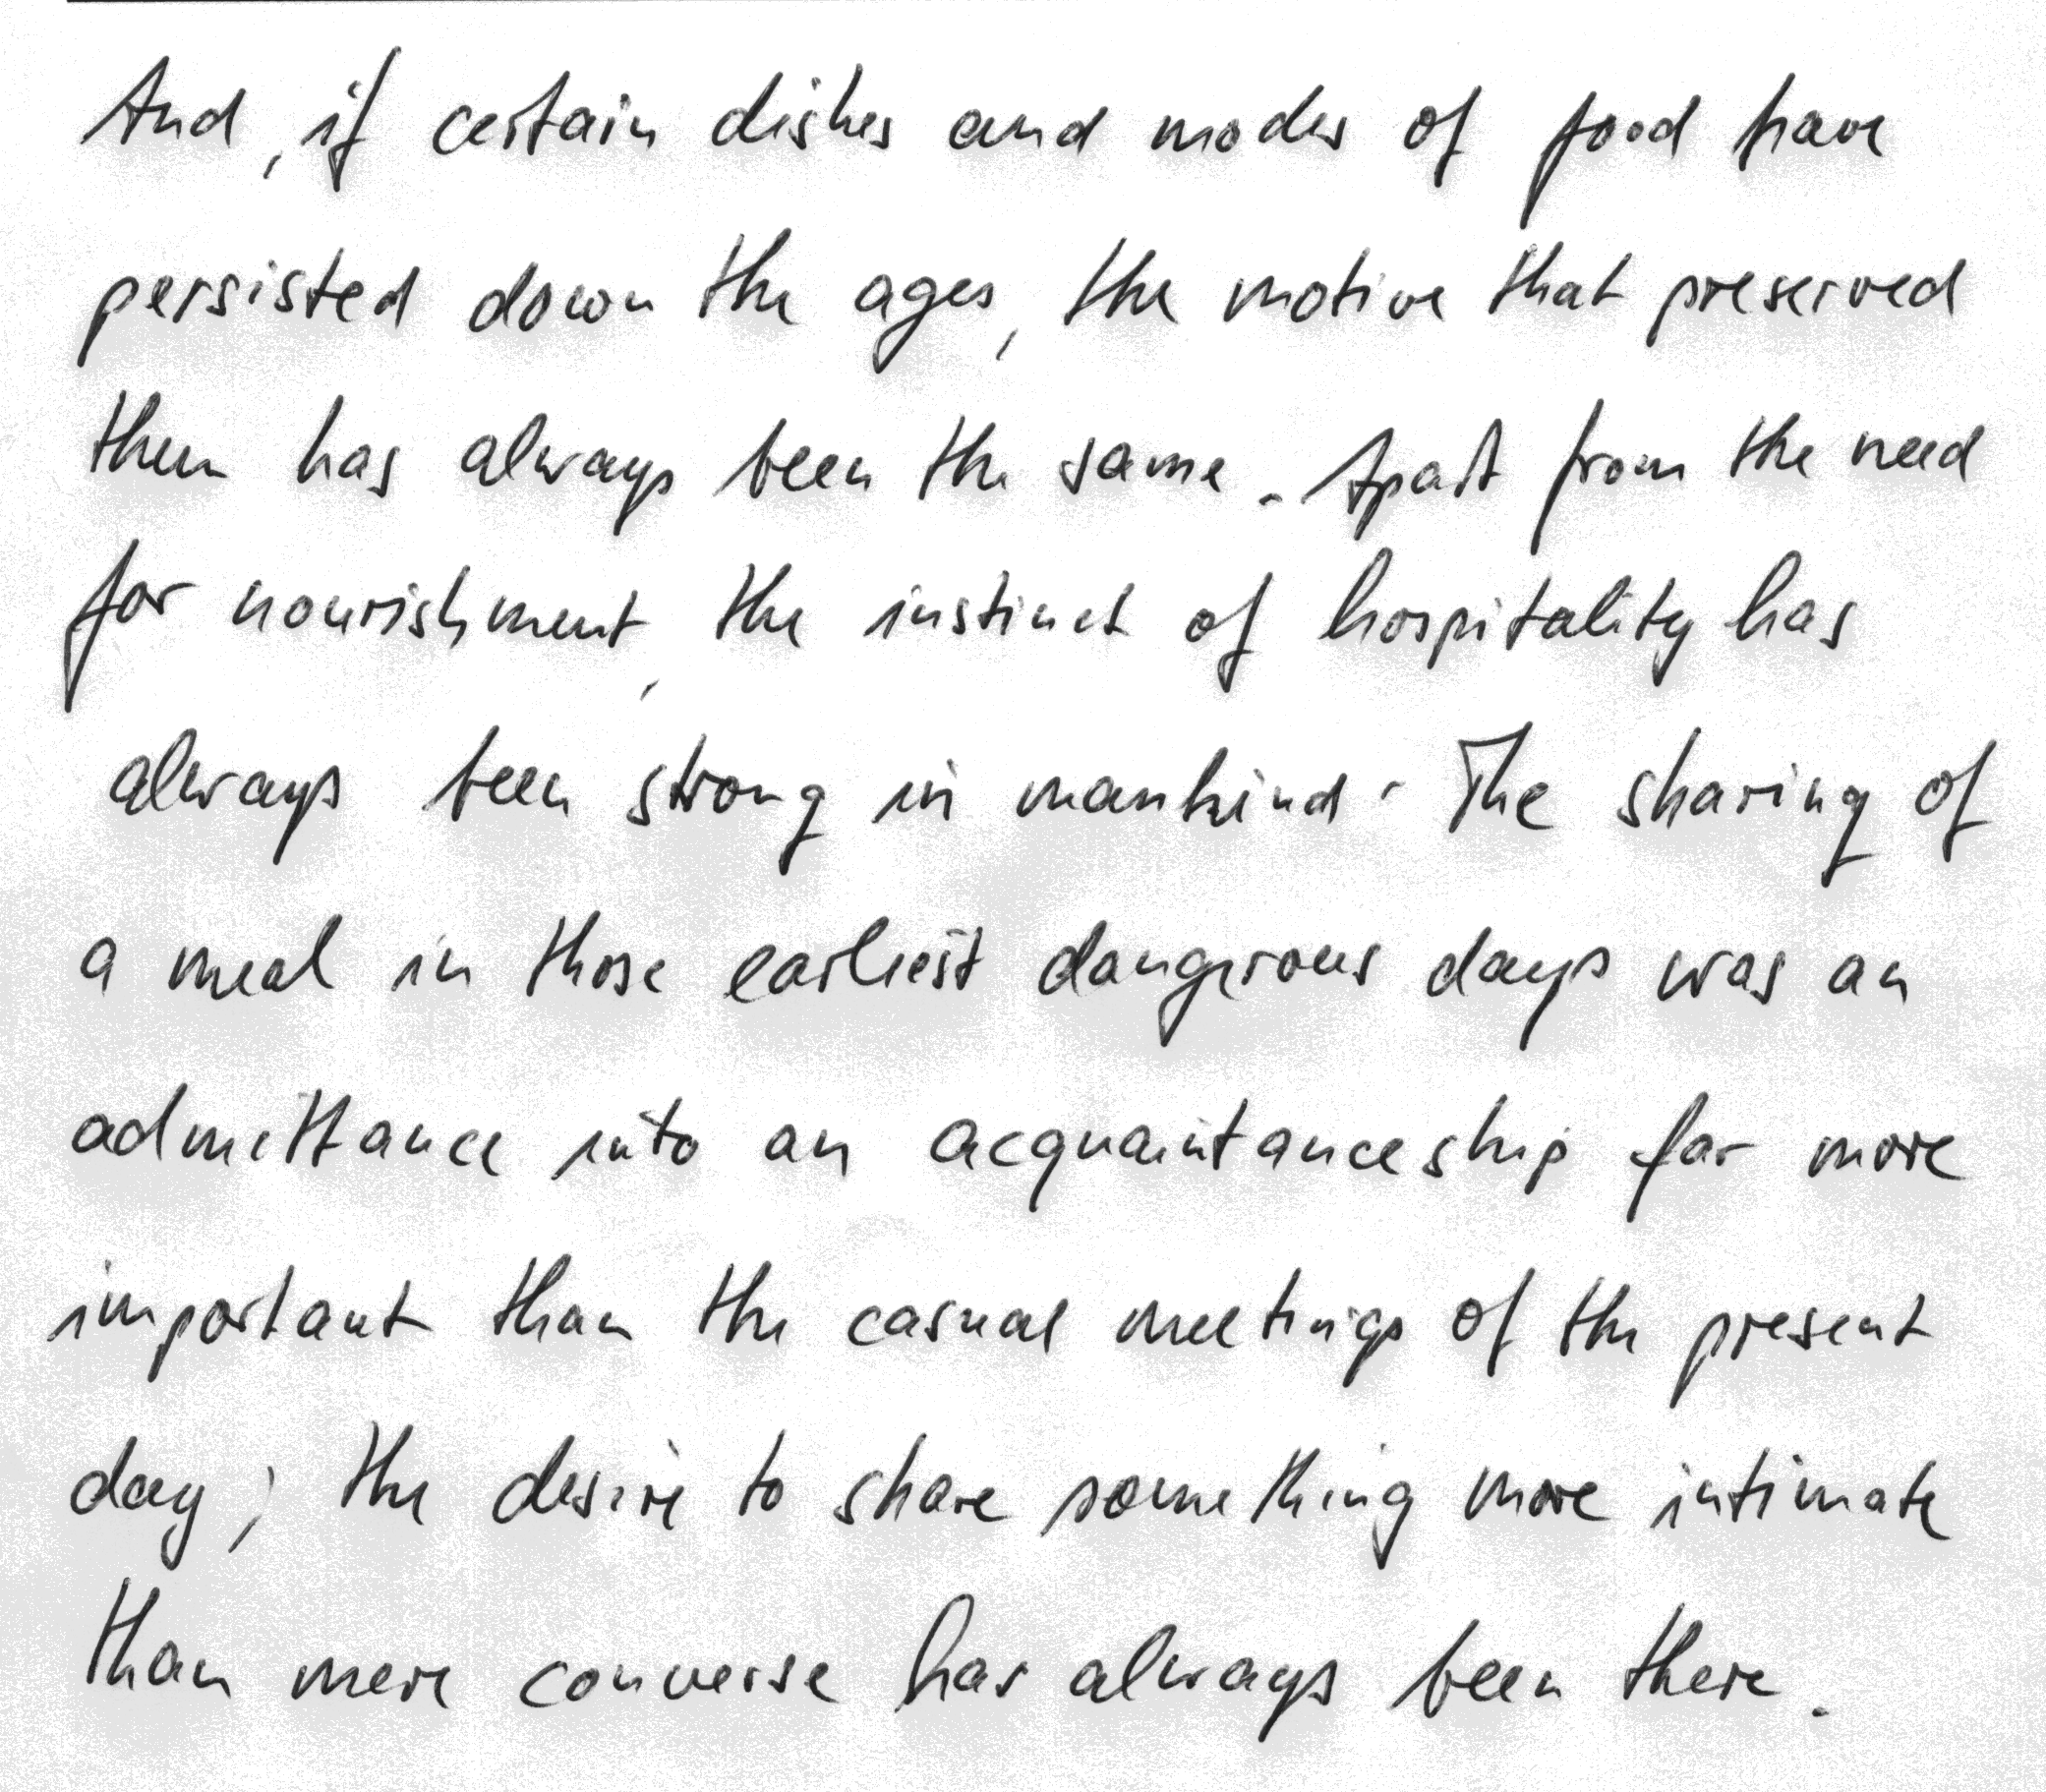

In [11]:
show_rand_paragraph(files)

# Combining Line labels into paragraph labels

In [37]:
lines = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
lines['text'] = lines.apply(lambda row: row.value.replace('|', ' '), axis=1)

In [38]:
lines.head(30)

filename result                                              value  \
0   a01-000u-00     ok                  A|MOVE|to|stop|Mr.|Gaitskell|from   
1   a01-000u-01     ok              nominating|any|more|Labour|life|Peers   
2   a01-000u-02     ok               is|to|be|made|at|a|meeting|of|Labour   
3   a01-000u-03    err                MPs|tomorrow|.|Mr.|Michael|Foot|has   
4   a01-000u-04     ok               put|down|a|resolution|on|the|subject   
5   a01-000u-05    err                 and|he|is|to|be|backed|by|Mr.|Will   
6   a01-000u-06     ok           Griffiths|,|MP|for|Manchester|Exchange|.   
7   a01-000x-00     ok       A|MOVE|to|stop|Mr.|Gaitskell|from|nominating   
8   a01-000x-01     ok      any|more|Labour|life|Peers|is|to|be|made|at|a   
9   a01-000x-02     ok      meeting|of|Labour|OMPs|tomorrow|.|Mr.|Michael   
10  a01-000x-03     ok      Foot|has|put|down|a|resolution|on|the|subject   
11  a01-000x-04     ok     and|he|is|to|be|backed|by|Mr.|Will|Griffiths|,   
12  a01-000x-05     ok                      OMP|for|Manchester|Exchange|.   
13   a01-003-00     ok  Though|they|may|gather|some|Left-wing|support|,|a   
14   a01-003-01     ok         large|majority|of|Labour|MPs|are|likely|to   
15   a01-003-02     ok      turn|down|the|Foot-Griffiths|resolution|.|Mr.   
16   a01-003-03     ok             Foot's|line|will|be|that|as|Labour|MPs   
17   a01-003-04     ok          opposed|the|Government|Bill|which|brought   
18   a01-003-05     ok        life|peers|into|existence|,|they|should|not   
19   a01-003-06     ok             now|put|forward|nominees|.|He|believes   
20   a01-003-07     ok        that|the|House|of|Lords|should|be|abolished   
21   a01-003-08     ok          and|that|Labour|should|not|take|any|steps   
22   a01-003-09    err     which|would|appear|to|"|prop|up|"|an|out-dated   
23   a01-003-10     ok                                      institution|.   
24  a01-003u-00     ok              Though|they|may|gather|some|Left-wing   
25  a01-003u-01     ok               support|,|a|large|majority|of|Labour   
26  a01-003u-02     ok              MPs|are|likely|to|turn|down|the|Foot-   
27  a01-003u-03    err        Griffiths|resolution|.|Mr.|Foot's|line|will   
28  a01-003u-04     ok                  be|that|as|Labour|MPs|opposed|the   
29  a01-003u-05     ok           Government|Bill|which|brought|life|peers   

                                                 text  
0                   A MOVE to stop Mr. Gaitskell from  
1               nominating any more Labour life Peers  
2                is to be made at a meeting of Labour  
3                 MPs tomorrow . Mr. Michael Foot has  
4                put down a resolution on the subject  
5                  and he is to be backed by Mr. Will  
6            Griffiths , MP for Manchester Exchange .  
7        A MOVE to stop Mr. Gaitskell from nominating  
8       any more Labour life Peers is to be made at a  
9       meeting of Labour OMPs tomorrow . Mr. Michael  
10      Foot has put down a resolution on the subject  
11     and he is to be backed by Mr. Will Griffiths ,  
12                      OMP for Manchester Exchange .  
13  Though they may gather some Left-wing support , a  
14         large majority of Labour MPs are likely to  
15      turn down the Foot-Griffiths resolution . Mr.  
16             Foot's line will be that as Labour MPs  
17          opposed the Government Bill which brought  
18        life peers into existence , they should not  
19             now put forward nominees . He believes  
20        that the House of Lords should be abolished  
21          and that Labour should not take any steps  
22     which would appear to " prop up " an out-dated  
23                                      institution .  
24              Though they may gather some Left-wing  
25               support , a large majority of Labour  
26              MPs are likely to turn down the Foot-  
27        Griffiths resolution . Mr. Foot's line wi

In [39]:
paragraphs = []
for fname in files:
    fname = fname[:-4]
    text = []
    rows = lines[lines.filename.str.startswith(fname+'-')]
    for i,t in rows.text.iteritems():
        text.append(t+' \n')
    paragraphs.append((fname+'.png', ''.join(text)))

In [40]:
len(paragraphs), len(files)

(1539, 1539)

In [41]:
len(files)

1539

In [42]:
df = pd.DataFrame(paragraphs, columns=['filename', 'text'])
df.head()

filename                                               text
0  a01-000u.png  A MOVE to stop Mr. Gaitskell from \nnominating...
1  a01-000x.png  A MOVE to stop Mr. Gaitskell from nominating \...
2   a01-003.png  Though they may gather some Left-wing support ...
3  a01-003u.png  Though they may gather some Left-wing \nsuppor...
4  a01-003x.png  Though they may gather some Left-wing support ...

# Word prep  (~120 words/paragraph - max: 170)

### Tokenize/Numericalize

In [43]:
tokens = Tokenizer().proc_all_mp(partition_by_cores(df.text))

In [44]:
tokens

[['a',
  't_up',
  'move',
  'to',
  'stop',
  'mr',
  '.',
  'gaitskell',
  'from',
  '\n',
  'nominating',
  'any',
  'more',
  'labour',
  'life',
  'peers',
  '\n',
  'is',
  'to',
  'be',
  'made',
  'at',
  'a',
  'meeting',
  'of',
  'labour',
  '\n',
  'mps',
  'tomorrow',
  '.',
  'mr',
  '.',
  'michael',
  'foot',
  'has',
  '\n',
  'put',
  'down',
  'a',
  'resolution',
  'on',
  'the',
  'subject',
  '\n',
  'and',
  'he',
  'is',
  'to',
  'be',
  'backed',
  'by',
  'mr',
  '.',
  'will',
  '\n',
  'griffiths',
  ',',
  'mp',
  'for',
  'manchester',
  'exchange',
  '.',
  '\n'],
 ['a',
  't_up',
  'move',
  'to',
  'stop',
  'mr',
  '.',
  'gaitskell',
  'from',
  'nominating',
  '\n',
  'any',
  'more',
  'labour',
  'life',
  'peers',
  'is',
  'to',
  'be',
  'made',
  'at',
  'a',
  '\n',
  'meeting',
  'of',
  'labour',
  'omps',
  'tomorrow',
  '.',
  'mr',
  '.',
  'michael',
  '\n',
  'foot',
  'has',
  'put',
  'down',
  'a',
  'resolution',
  'on',
  'the',
 

In [45]:
idx = np.argmax([len(o) for o in tokens])
idx, len(tokens[idx]), tokens[idx]

(933,
 170,
 [' ',
  't_up',
  'when',
  'he',
  't_up',
  'saw',
  't_up',
  'trelawny',
  "'s",
  't_up',
  'printed',
  't_up',
  'letter',
  ',',
  '\n ',
  't_up',
  'lord',
  't_up',
  'sidney',
  't_up',
  'wrote',
  'to',
  't_up',
  'douglas',
  't_up',
  'kinnaird',
  '\n ',
  't_up',
  'saying',
  't_up',
  'that',
  'it',
  't_up',
  'was',
  't_up',
  'incorrect',
  't_up',
  'throughout',
  '.',
  'he',
  '\n ',
  't_up',
  'had',
  'no',
  't_up',
  'sooner',
  't_up',
  'heard',
  't_up',
  'from',
  't_up',
  'count',
  't_up',
  'gamba',
  't_up',
  'and',
  '\n ',
  't_up',
  'fletcher',
  't_up',
  'that',
  't_up',
  'byron',
  't_up',
  'would',
  't_up',
  'have',
  't_up',
  'wished',
  '\n ',
  't_up',
  'his',
  't_up',
  'body',
  'to',
  't_up',
  'return',
  'to',
  't_up',
  'england',
  't_up',
  'than',
  't_up',
  'that',
  '\n ',
  't_up',
  'course',
  't_up',
  'was',
  "'",
  't_up',
  'immediately',
  't_up',
  'carried',
  't_up',
  'into',
  '\n 

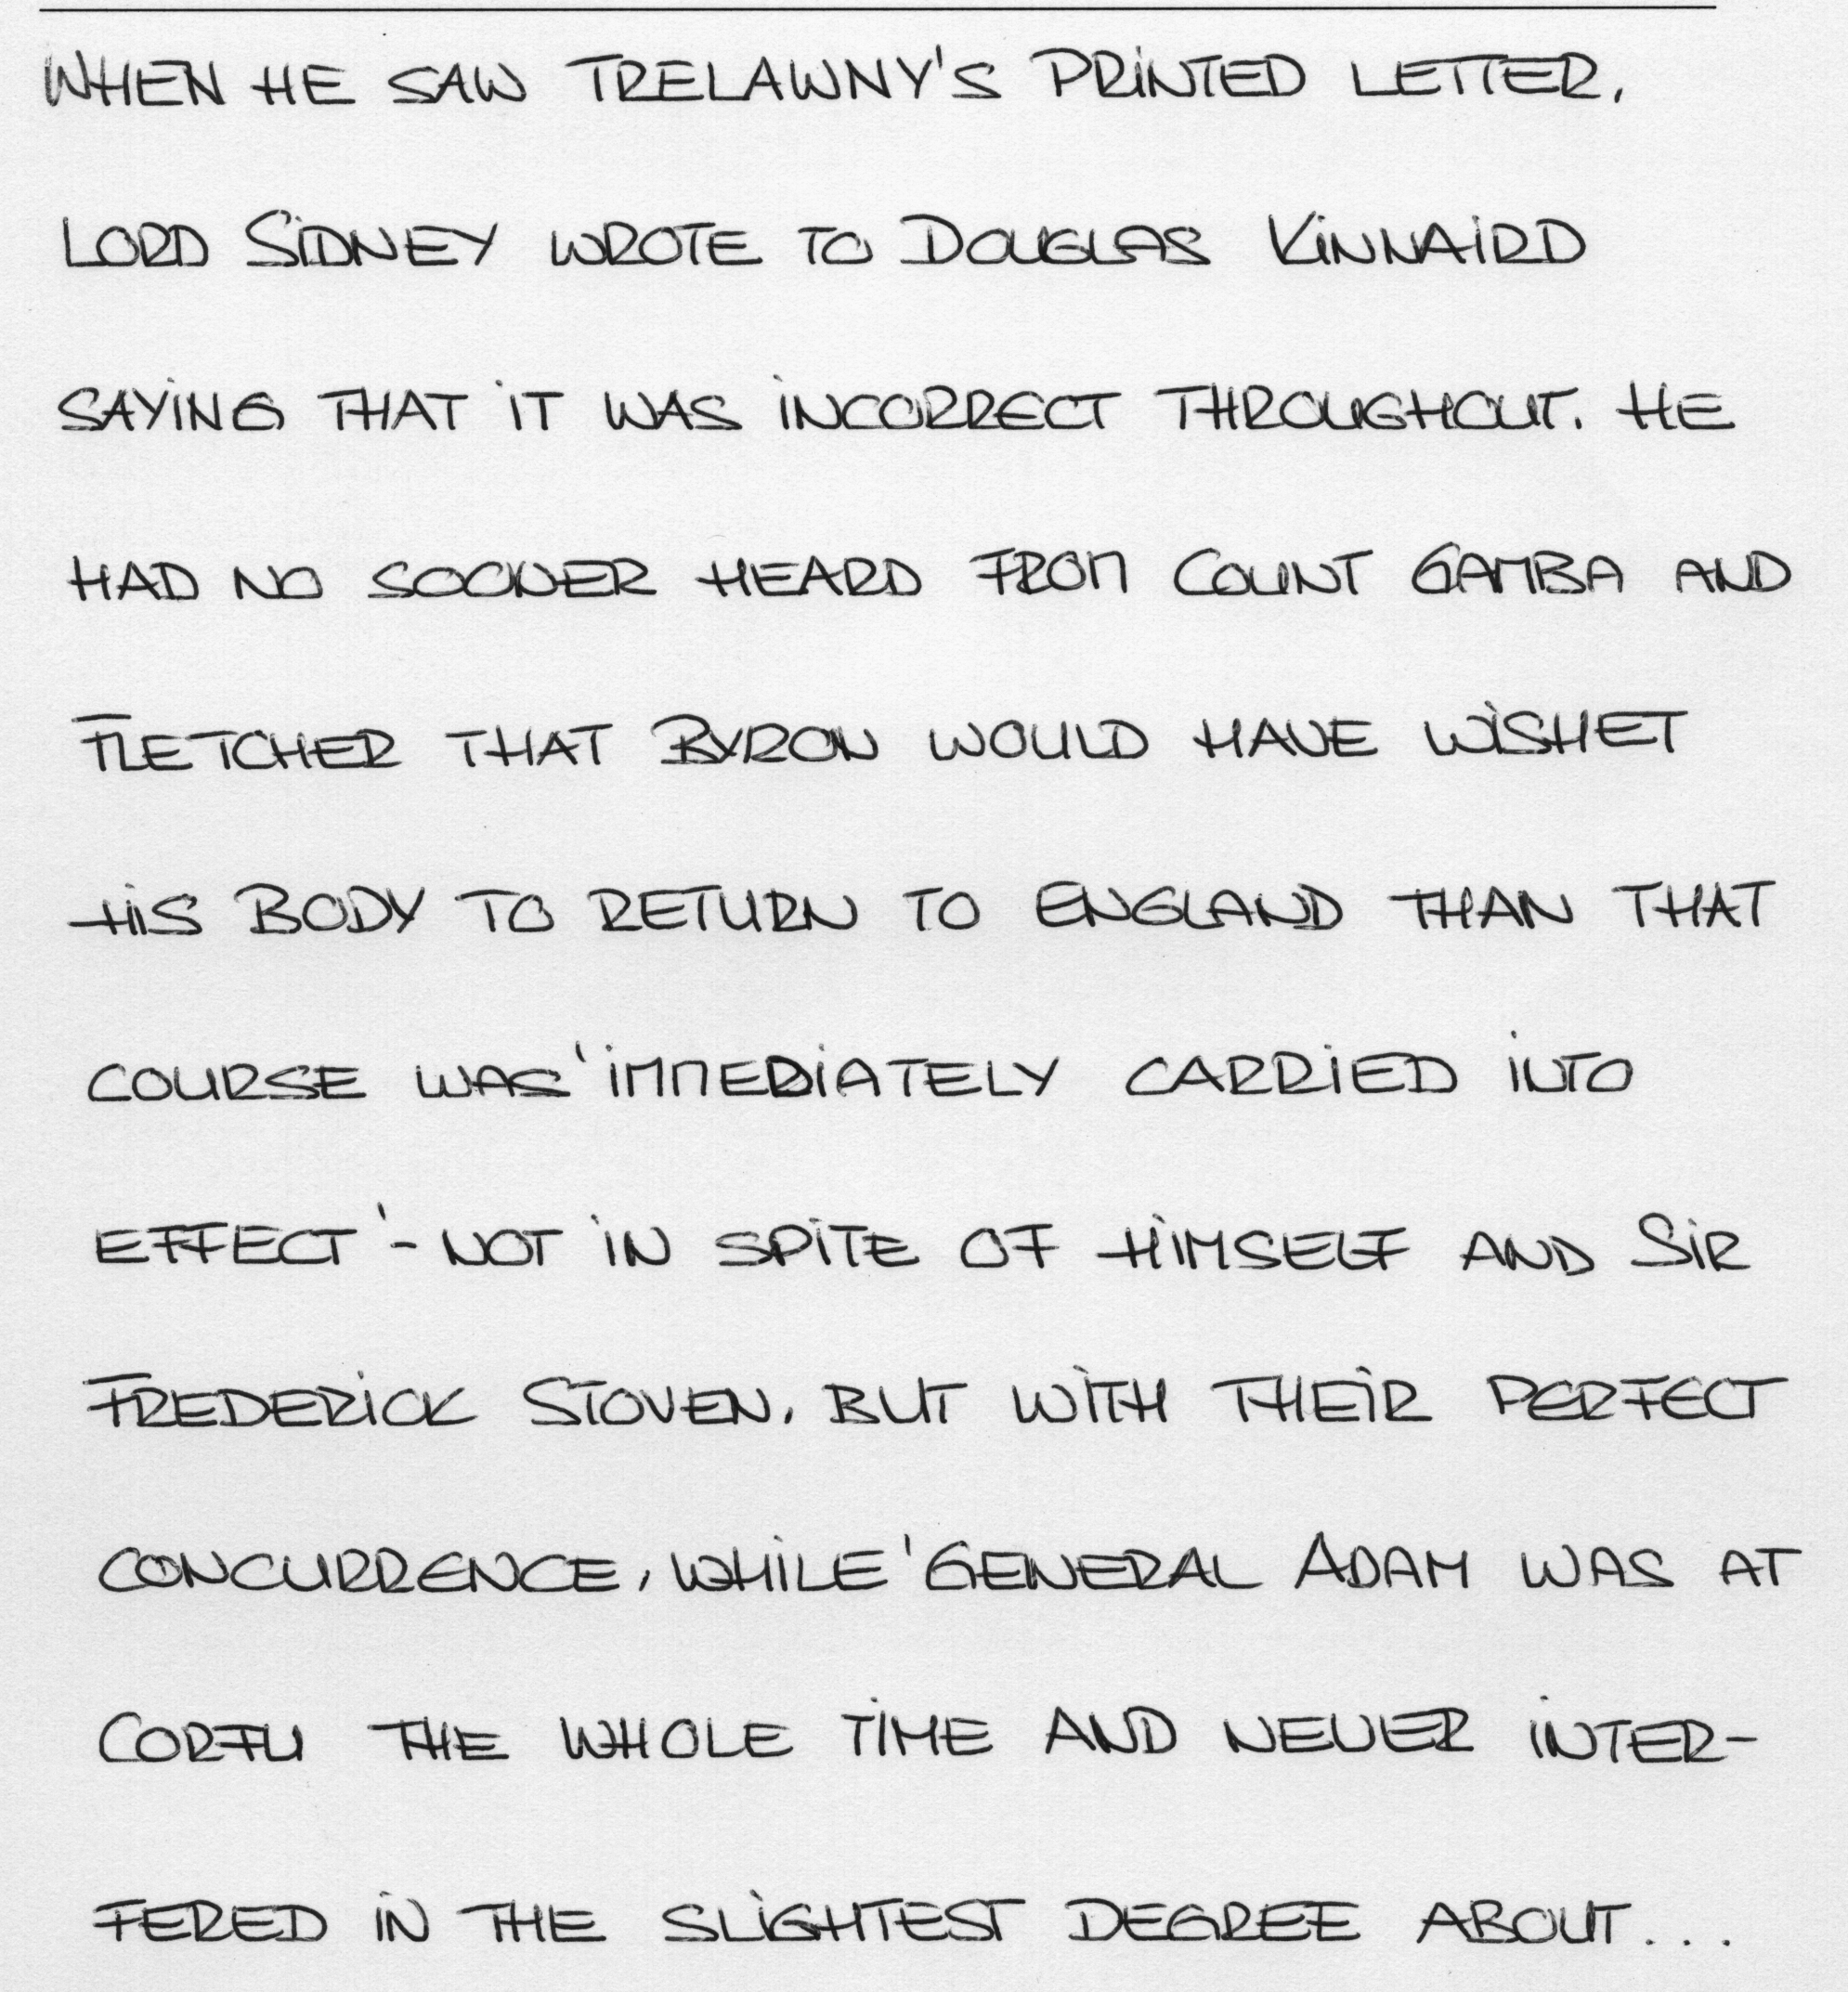

In [91]:
Image.open(PATH/'paragraphs'/'g07-000a.png')

In [59]:
np.percentile([len(o) for o in tokens], 98)

118.0

In [51]:
freq = Counter(word for line in tokens for word in line)
freq.most_common(25)

[('\n', 13265),
 ('the', 6491),
 ('.', 5561),
 (',', 5558),
 ('of', 3221),
 ('to', 2708),
 ('and', 2615),
 ('a', 2429),
 ('in', 2044),
 ('"', 1601),
 ('he', 1210),
 ('that', 1187),
 ('was', 1154),
 ('-', 1112),
 ('is', 1004),
 ('it', 983),
 ("'", 977),
 ('for', 890),
 ('as', 771),
 ('with', 766),
 ('his', 761),
 ('i', 746),
 ('had', 742),
 ('be', 731),
 ('on', 729)]

In [49]:
max_vocab=50000
min_freq=2

In [52]:
itos = [word for word,count in freq.most_common(max_vocab) if count>min_freq]
itos.insert(0, '_pad_')
itos.insert(1, '_bos_')
itos.insert(2, '_eos_')
itos.insert(3, '_unk_')

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([1]+[stoi[word] for word in line]+[2]) for line in tokens])

In [56]:
TMP_PATH = PATH/'tmp'
np.save(TMP_PATH/'paragraph_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'paragraph_itos.pkl', 'wb'))

In [55]:
df['ids'] = [' '.join(str(p) for p in o) for o in ids]
df.tail()

filename                                               text  \
1534  r06-121.png  At the school , which is charming , ci- \nvili...   
1535  r06-126.png  For his sake we chose the more \nserious of th...   
1536  r06-130.png  At the entrance of the cinema the \ndoorman wa...   
1537  r06-137.png  The doorman turned his attention \nto the next...   
1538  r06-143.png  In the train going back to London I sat \nbesi...   

                                                    ids  
1534  1 30 5 401 7 39 18 544 7 3 4 3 10 1599 7 5 88 ...  
1535  1 21 24 2305 46 3 5 67 4 2529 8 5 88 1750 15 4...  
1536  1 30 5 2902 8 5 1077 5 4 3 16 1293 12 1055 21 ...  
1537  1 5 3 396 24 1501 4 9 5 274 744 17 3117 3 41 5...  
1538  1 12 5 875 162 118 9 203 25 716 4 1396 146 130...

In [57]:
# length of longest string -> seq_len
csv.ids.map(lambda x: len(x.split(' '))).max()

170

### CSV

In [6]:
CSV = PATH/'paragraphs.csv'
# df.to_csv(CSV, columns=['filename', 'ids'], index=False)
csv = pd.read_csv(CSV)

In [7]:
# paragraph_ids = np.load(TMP_PATH/'paragraph_ids.npy')
itos = pickle.load(open(TMP_PATH/'paragraph_itos.pkl', 'rb'))

In [8]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

231

### Preprocess (rotate, normalize)

In [9]:
f = resnet34
sz = 500
bs = 10

In [10]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'paragraphs', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [11]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [18]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

### Verify transforms

In [19]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ' '.join([itos[i] for i in ints])

In [20]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

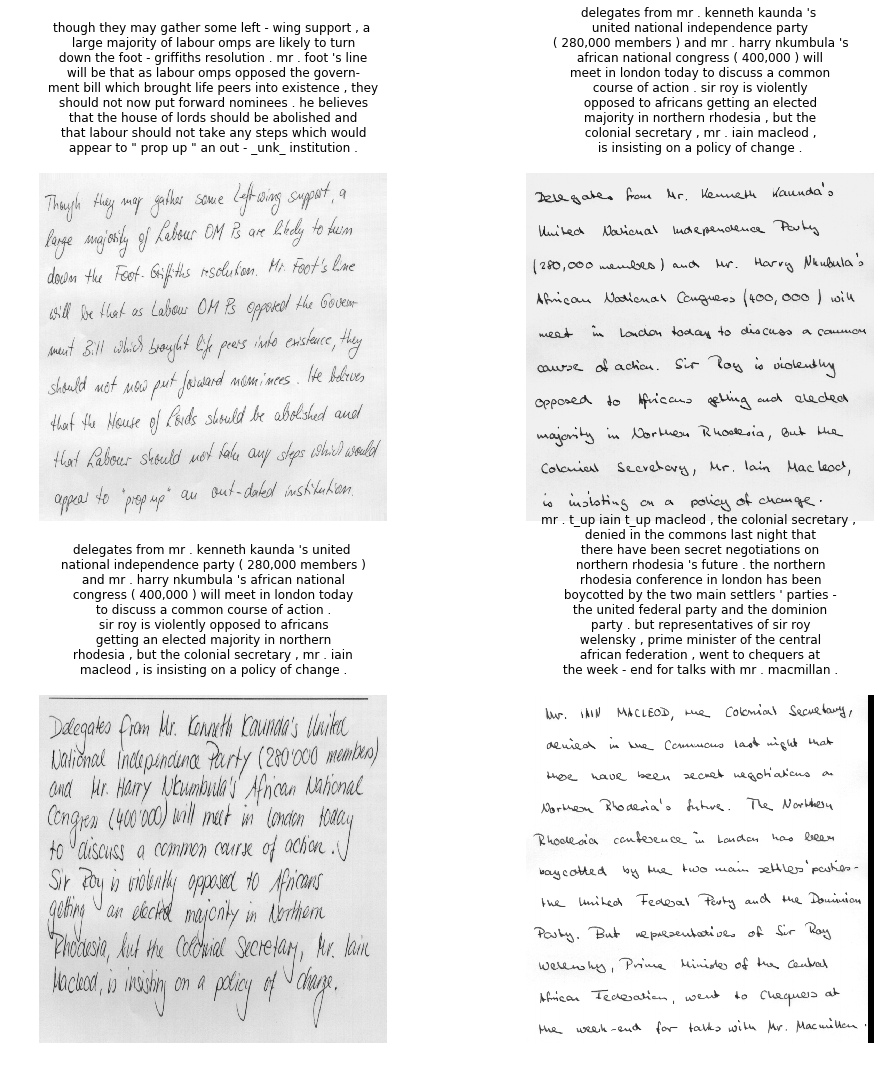

In [21]:
fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.5}, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(x[i], ax=ax, title=t)

## Loss Fn

In [12]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target[:sl]
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [21]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch (unreleased)

In [22]:
def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)
    
    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

## Levenshtein Error Rate

In [13]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [14]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

In [15]:
def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    #_,sl_in,vs = preds.size()  #=> ([bs, 16, 80])
    
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = label_text(res[i])
        t = label_text(targs[i])
        error += wer(t,p)
    return error/bs

# Arch

## Show, Attend, Tell

In [17]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        net = f(True)
        modules = list(net.children())[:-3]    #(8,8,256)
        self.base = nn.Sequential(*modules)

        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [18]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [19]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [20]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [21]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = Decoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [22]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 120, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
# learn.model = SingleModel(to_gpu(rnn))   #modify model w/out losing learned weights...
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

### Custom Head

In [42]:
fake_head = nn.Sequential(nn.Conv2d(256, 256, 3, stride=2, padding=1))
models = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=fake_head)
learn = ConvLearner(data, models)

In [43]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [ ]:
# 11x11 => 121

drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)        # 7x7
        x = self.sconv1(x)        # 4x4
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)        # 2x2
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)        # 1x1
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [ ]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f, 0, 0, 0, xtra_cut=2)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

### CTC-Hybrid

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.2, p=(2,2)):
        super().__init__()
        self.p = p
        
        self.drop = nn.Dropout(drop)
        self.conv = nn.Conv2d(ni*p[0]*p[1], nh, 3, padding=1)  #maintain size
        self.bn   = nn.BatchNorm2d(nh)
    
    def tile(self, x):
        bs, nf, h, w = x.size()   # Note: different order than ReNet tile!!!
        p_height = self.p[0]
        p_width  = self.p[1]

        assert h % p_height == 0
        assert w % p_width  == 0

        new_height = int(h / p_height)
        new_width  = int(w / p_width)

        x = x.view(bs, nf, new_height, p_height, new_width, p_width)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(bs, nf * p_height * p_width, new_height, new_width)
        return x

    def forward(self, x):
        x = self.tile(x)
        x = self.bn(self.conv(self.drop(x)))
        x = F.leaky_relu(x)
        return x

In [31]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

In [54]:
class Hybrid(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(4,2))
        self.block2 = ReNetBlock(32, nh, p=(4,1))
        self.block3 = ReNetBlock(64, nh, p=(4,1))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(1,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([30, 1, 16, 80])
        
        return x.squeeze(1)

In [55]:
net = Hybrid(100, len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss
learn.clip = 10.
learn.metrics = [word_error_rate]

### Train

In [23]:
lr=1e-3
learn.fit(lr, 1, cycle_len=1)

  3%|▎         | 4/131 [03:30<1:55:10, 54.41s/it, loss=999]  

KeyboardInterrupt: 